In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np


RANDOM_STATE=12345
RANDOM_SEED=12345

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif as MIC
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier


In [2]:
'''функция для обработки выбросов, 
   заменяем значения лежащие за пределами 3 межквартильных размахов
   на 25-ю персентиль-1.5 межквартильных размаха и на 75-ю персентиль+1.5 межквартильных размаха
      
'''

def outliers(df, c_name):
    u_lim=np.percentile(df[c_name],75)
    l_lim=np.percentile(df[c_name],25)
    iqr=u_lim-l_lim
    
    df.loc[df[c_name]>u_lim+1.5*iqr,c_name]=u_lim+1.5*iqr
    df.loc[df[c_name]<l_lim-1.5*iqr,c_name]=l_lim-1.5*iqr
    
    return df[c_name]
       

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:.3f}'.format

In [4]:
path='D:/counterparty-analysis/'

In [5]:
df_2021=pd.read_csv(path+'agents2021.csv')
df_2020=pd.read_csv(path+'agents2020.csv')
df_2019=pd.read_csv(path+'agents2019.csv')

In [6]:
df_2019.head()

,Unnamed: 0,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.","2016, Нематериальные активы, RUB","2017, Нематериальные активы, RUB","2018, Нематериальные активы, RUB","2016, Основные средства , RUB","2017, Основные средства , RUB","2018, Основные средства , RUB","2016, Внеоборотные активы, RUB","2017, Внеоборотные активы, RUB","2018, Внеоборотные активы, RUB","2016, Дебиторская задолженность, RUB","2017, Дебиторская задолженность, RUB","2018, Дебиторская задолженность, RUB","2016, Оборотные активы, RUB","2017, Оборотные активы, RUB","2018, Оборотные активы, RUB","2016, Уставный капитал , RUB","2017, Уставный капитал , RUB","2018, Уставный капитал , RUB","2016, Капитал и резервы, RUB","2017, Капитал и резервы, RUB","2018, Капитал и резервы, RUB","2016, Заёмные средства (долгосрочные), RUB","2017, Заёмные средства (долгосрочные), RUB","2018, Заёмные средства (долгосрочные), RUB","2016, Долгосрочные обязательства, RUB","2017, Долгосрочные обязательства, RUB","2018, Долгосрочные обязательства, RUB","2016, Заёмные средства (краткосрочные), RUB","2017, Заёмные средства (краткосрочные), RUB","2018, Заёмные средства (краткосрочные), RUB","2016, Кредиторская задолженность, RUB","2017, Кредиторская задолженность, RUB","2018, Кредиторская задолженность, RUB","2016, Краткосрочные обязательства, RUB","2017, Краткосрочные обязательства, RUB","2018, Краткосрочные обязательства, RUB","2016, Выручка, RUB","2017, Выручка, RUB","2018, Выручка, RUB","2016, Себестоимость продаж, RUB","2017, Себестоимость продаж, RUB","2018, Себестоимость продаж, RUB","2016, Прибыль (убыток) до налогообложения , RUB","2017, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) до налогообложения , RUB","2016, Прибыль (убыток) от продажи, RUB","2017, Прибыль (убыток) от продажи, RUB","2018, Прибыль (убыток) от продажи, RUB"
0,0,0,0,0.000,0,0.000,0,2895541.401,6245859.873,9050955.414,1889724203.822,1803724203.822,2145239490.446,1928685350.318,1880842038.217,2440077707.006,3583765605.096,3683358598.726,3475461146.497,5159380254.777,5897326114.650,6077447770.701,629400000.000,629400000.000,629400000.000,2673019745.223,2971017197.452,2289273885.350,0.000,0.000,0.000,249877707.006,258973248.408,271221019.108,0.000,0.000,392391719.745,4080056050.955,4452921656.051,5476906369.427,4165168152.866,4548177707.006,5957030573.248,26676980254.777,41626929936.306,37039522292.994,21568144585.987,33354425477.707,34383128662.420,3179696815.287,6167666878.981,746182802.548,3280355414.013,6200119745.223,871619108.280
1,1,1,0,0.000,0,0.000,0,0.000,38853.503,34394.904,144810828.025,148715286.624,152642675.159,145678343.949,149798726.115,153892356.688,55847770.701,46782165.605,156347770.701,148915286.624,189898726.115,291463694.268,1345859.873,1345859.873,1345859.873,272664968.153,277408280.255,310658598.726,0.000,0.000,0.000,3108280.255,4528025.478,5033757.962,9745222.930,47606369.427,63498726.115,9075159.236,10154777.070,66164968.153,18820382.166,57761146.497,129663694.268,255489808.917,257366878.981,543430573.248,205681528.662,205532484.076,416979617.834,12123566.879,6944585.987,44800636.943,16300636.943,11091719.745,51357324.841
2,2,2,7,5.500,1,132825.299,2,2468152.866,12880254.777,8694904.459,969806369.427,944416560.510,928738853.503,973274522.293,1036412101.911,1018682165.605,281467515.924,232107006.369,228049681.529,1286917197.452,1489083439.490,1590216560.510,19644585.987,19644585.987,19644585.987,2110424840.764,2339440127.389,2378698089.172,0.000,0.000,0.000,13398089.172,11831210.191,2843949.045,0.000,0.000,0.000,82468789.809,88571974.522,123771337.580,136368789.809,174224203.822,227356687.898,2786577070.064,2699396815.287,2592420382.166,2038075796.178,2178598089.172,2316724203.822,502666242.038,364422929.936,85529936.306,414858598.726,161131847.134,-92989808.917
3,3,3,0,0.000,0,0.000,0,0.000,0.000,0.000,8

In [7]:
# переименование колонок для единого формата названий
df_2020=df_2020.rename(columns=
     {'Факт. 1':'Факт 1_LY',                                            
    'Факт. 2':'Факт 2_LY',                                         
    'Факт. 3':'Факт 3_LY',                                            
    'Факт. 4': 'Факт 4_LY',                                         
    'Факт. 5':'Факт 5_LY',                                        
    'Факт. 6':'Факт 6_LY',                                             
    'Факт. 7':'Факт 7_LY',                                           
    'Факт. 8':'Факт 8_LY',                                            
    'Факт. 9':'Факт 9_LY',                                         
   'Факт. 10':'Факт 10_LY',                                         
   'Факт. 11':'Факт 11_LY',                                        
   'Факт. 12':'Факт 12_LY',                                           
   'Факт. 13':'Факт 13_LY',                                         
   'Факт. 14':'Факт 14_LY',                                       
   'Факт. 15':'Факт 15_LY',                                          
   'Факт. 16':'Факт 16_LY',                                           
   'Факт. 17':'Факт 17_LY',                                        
   'Факт. 18':'Факт 18_LY',                                           
   'Факт. 19':'Факт 19_LY',                                         
   'Факт. 20':'Факт 20_LY',                                           
   'Факт. 21':'Факт 21_LY',                                          
   'Факт. 22':'Факт 22_LY',                                          
   'Факт. 23':'Факт 23_LY',                                        
   'Факт. 24':'Факт 24_LY',                                        
   'Факт. 25':'Факт 25_LY',                                           
   'Факт. 26':'Факт 26_LY',                                          
   'Факт. 27':'Факт 27_LY',                                            
   'Факт. 28':'Факт 28_LY',                                        
   'Факт. 29':'Факт 29_LY',                                         
   'Факт. 30':'Факт 30_LY',                                           
   'Факт. 31':'Факт 31_LY',                                         
   'Факт. 32':'Факт 32_LY',                                        
   'Факт. 33':'Факт 33_LY',                                          
   'Факт. 34':'Факт 34_LY',                                            
   'Факт. 35':'Факт 35_LY',                                           
   'Факт. 36':'Факт 36_LY',                                           
   'Факт. 37':'Факт 37_LY',                                          
   'Факт. 38':'Факт 38_LY',                                          
   'Факт. 39':'Факт 39_LY',                                            
   'Факт. 40':'Факт 40_LY',                                            
   'Факт. 41':'Факт 41_LY',                                         
   'Факт. 42':'Факт 42_LY',                                            
   'Факт. 43':'Факт 43_LY',                                         
   'Факт. 44':'Факт 44_LY',                                         
   'Факт. 45':'Факт 45_LY',                                          
   'Факт. 46':'Факт 46_LY',                                           
   'Факт. 47':'Факт 47_LY',                                          
   'Факт. 48':'Факт 48_LY',                                          
   'Факт. 49':'Факт 49_LY',                                           
   'Факт. 50':'Факт 50_LY',                                        
   'Факт. 51':'Факт 51_LY',                                          
   'Факт. 52':'Факт 52_LY',                                         
   'Факт. 53':'Факт 53_LY',                                           
   'Факт. 54':'Факт 54_LY',                                          
   'Факт. 55':'Факт 55_LY',                                        
   'Факт. 56':'Факт 56_LY',                                         
   'Факт. 57':'Факт 57_LY',                                         
   'Факт. 58':'Факт 58_LY',                                        
   'Факт. 59':'Факт 59_LY',                                       
   'Факт. 60':'Факт 60_LY'}   

)

In [8]:
#здесь хранятся данные по весам Фактов за 2020й год
tmp_df=df_2020[[
    'Наименование ДП',
    'Факт 1_LY',                                            
    'Факт 2_LY',                                         
    'Факт 3_LY',                                            
    'Факт 4_LY',                                         
    'Факт 5_LY',                                        
    'Факт 6_LY',                                             
    'Факт 7_LY',                                           
    'Факт 8_LY',                                            
    'Факт 9_LY',                                         
   'Факт 10_LY',                                         
   'Факт 11_LY',                                        
   'Факт 12_LY',                                           
   'Факт 13_LY',                                         
   'Факт 14_LY',                                       
   'Факт 15_LY',                                          
   'Факт 16_LY',                                           
   'Факт 17_LY',                                        
   'Факт 18_LY',                                           
   'Факт 19_LY',                                         
   'Факт 20_LY',                                           
   'Факт 21_LY',                                          
   'Факт 22_LY',                                          
   'Факт 23_LY',                                        
   'Факт 24_LY',                                        
   'Факт 25_LY',                                           
   'Факт 26_LY',                                          
   'Факт 27_LY',                                            
   'Факт 28_LY',                                        
   'Факт 29_LY',                                         
   'Факт 30_LY',                                           
   'Факт 31_LY',                                         
   'Факт 32_LY',                                        
   'Факт 33_LY',                                          
   'Факт 34_LY',                                            
   'Факт 35_LY',                                           
   'Факт 36_LY',                                           
   'Факт 37_LY',                                          
   'Факт 38_LY',                                          
   'Факт 39_LY',                                            
   'Факт 40_LY',                                            
   'Факт 41_LY',                                         
   'Факт 42_LY',                                            
   'Факт 43_LY',                                         
   'Факт 44_LY',                                         
   'Факт 45_LY',                                          
   'Факт 46_LY',                                           
   'Факт 47_LY',                                          
   'Факт 48_LY',                                          
   'Факт 49_LY',                                           
   'Факт 50_LY',                                        
   'Факт 51_LY',                                          
   'Факт 52_LY',                                         
   'Факт 53_LY',                                           
   'Факт 54_LY',                                          
   'Факт 55_LY',                                        
   'Факт 56_LY',                                         
   'Факт 57_LY',                                         
   'Факт 58_LY',                                        
   'Факт 59_LY',                                       
   'Факт 60_LY'
        
]]

In [9]:
df_2021.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 136 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   Unnamed: 0                                         int64  
 1   Наименование ДП                                    int64  
 2   Макс. ПДЗ за 2019 год, дней                        int64  
 3   Сред. ПДЗ за 2019 год, дней                        float64
 4   Кол-во просрочек свыше 5-ти дней за 2019 год, шт.  int64  
 5   Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.  float64
 6   Кол-во раз ПДЗ за 2019 год, шт.                    int64  
 7   Макс. ПДЗ за 2020 год, дней                        int64  
 8   Сред. ПДЗ за 2020 год, дней                        float64
 9   Кол-во просрочек свыше 5-ти дней за 2020 год, шт.  int64  
 10  Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.  float64
 11  Кол-во раз ПДЗ за 2020 год, шт.                    int64 

In [10]:
df_2021=df_2021.rename(columns={
    'Факт. 20':'Факт 20',                                        
   'Факт. 21':'Факт 21',                                         
   'Факт.32':'Факт 32',                                          
   'Факт.31':'Факт 31',                                           
    'Факт.23':'Факт 23'                                             
})

In [11]:
# добавим данные по весам Фактов за прошлый год
total_df=pd.merge(df_2021,tmp_df,on='Наименование ДП', how='left')

In [12]:
# первым целевым признаком будет сам факт возниктовения задолженности
total_df['TARGET']=total_df[['ПДЗ 1-30','ПДЗ 31-90','ПДЗ 91-365','ПДЗ более 365']].max(axis=1)

In [13]:
# наименование плательщика удалим, для расчетов оно бесполезно
# также удалим данные по суммарному весу всех Фактов
total_df=total_df.drop(['Наименование ДП','Итого','Unnamed: 0'], axis=1)

In [14]:
#заменим все пропуски нулями
total_df=total_df.replace('Х',0)
total_df=total_df.replace('Н/Д',0)
total_df=total_df.fillna(0)

In [15]:
target_columns=['TARGET','ПДЗ 1-30','ПДЗ 31-90','ПДЗ 91-365','ПДЗ более 365']

In [16]:
# вторым целевым признаком для нас будет тип задолженности:
#1:'ПДЗ 1-30'
#2:'ПДЗ 31-90'
#3:'ПДЗ 91-365'
#4:'ПДЗ более 365'
total_df['МАКС_ПДЗ_2021']=total_df.apply(lambda x: max(x['ПДЗ 1-30']*1,x['ПДЗ 31-90']*2,x['ПДЗ 91-365']*3,x['ПДЗ более 365']*4), axis = 1)

In [17]:
''' удалим данные за 2020 год, чтобы не обучать модель на показателях будущего
'''
leaks=[]
for c in total_df.columns:
    if '2020' in c: leaks.append(c)
        

In [18]:
total_df=total_df.drop(leaks, axis=1)

In [19]:
'''удалим данные по ПДЗ'''
pdz_dict=['Макс. ПДЗ за 2019 год, дней',
          'Сред. ПДЗ за 2019 год, дней',
          'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',
          'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.',
          'Кол-во раз ПДЗ за 2019 год, шт.'
             
]

total_df=total_df.drop(pdz_dict, axis=1)

In [20]:
'''удалим оценки, т.к. они формируются на основании данных 2020 года тоже
'''

feat_new_dict=[                  
  'Оценка потенциала контрагента 1, руб.',              
  'Оценка потенциала контрагента 2, руб.',                    
   ]

total_df=total_df.drop(feat_new_dict, axis=1)    

In [21]:
total_df.describe().T

,count,mean,std,min,25%,50%,75%,max
"2016, Нематериальные активы, RUB",325.000,34739854.973,239929478.993,0.000,0.000,0.000,2547.771,3126233121.019
"2017, Нематериальные активы, RUB",325.000,42659584.517,383346906.418,0.000,0.000,0.000,5095.541,6320582802.548
"2018, Нематериальные активы, RUB",325.000,51211796.178,443468756.583,0.000,0.000,0.000,26751.592,7549617834.395
"2019, Нематериальные активы, RUB",325.000,63559219.990,541350762.873,0.000,0.000,0.000,50955.414,8820049044.586
"2016, Основные средства , RUB",325.000,5192592401.764,42244099937.070,0.000,85350.318,11328662.420,126168789.809,703099619745.223
"2017, Основные средства , RUB",325.000,6272015139.637,55046559784.526,0.000,142038.217,13991082.803,126291082.803,937907628025.478
"2018, Основные средства , RUB",325.000,7443572133.268,61693549296.313,0.000,2580254.777,29036942.675,205780254.777,1051440103821.656
"2019, Основные средства , RUB",325.000,8233860876.041,61708463430.566,0.000,3705095.541,30658598.726,264937579.618,1037724263694.267
"2016, Внеоборотные активы, RUB",325.000,8032304830.965,51902318401.857,-17834.395,105095.541,13672611.465,171355414.013,738656578980.892
"2017, Внеоборотные активы, RUB",325.000,8394670432.141,62482084159.014,0.000,401910.828,18281528.662,196561783.439,992730682165.605


In [22]:
y='2019'
total_df[y+'Доход_1, RUB']=(total_df[y+', Капитал и резервы, RUB']
                            +total_df[y+', Себестоимость продаж, RUB']
                            +total_df[y+', Выручка, RUB']
                            +total_df[y+', Прибыль (убыток) до налогообложения , RUB'])

cut_labels = ['Отрицательный доход', 'Микро', 'Малый', 'Средний','Крупный']
cut_bins = [-10**12,0, 120*10**6, 8*10**8, 2*10**9,10**15]

total_df['Тип_предприятия'] = pd.cut(total_df['2019Доход_1, RUB'],
                       bins=cut_bins,
                       labels=cut_labels)

total_df=total_df.drop('2019Доход_1, RUB', axis=1)

In [23]:
for c in total_df.columns:
    if c!='Статус' and 'Факт' not in c and c!='Тип_предприятия':
        total_df[c]=outliers(total_df,c)

In [24]:
# удалим целевые колонки и оставим только независимые переменные
features=total_df.drop('МАКС_ПДЗ_2021', axis=1)
features=features.drop(target_columns, axis=1)

In [25]:
# целевая переменная
target=total_df['TARGET']

In [26]:
features_train, features_test, target_train, target_test=train_test_split(features, target, test_size=.2,random_state=RANDOM_STATE)

In [27]:
'''
Здесь мы делаем признаки для существующих клиентов

'''
def make_features_current_clients(df):
    f_list=[                                                           
   '2016, Нематериальные активы, RUB', '2017, Нематериальные активы, RUB', '2018, Нематериальные активы, RUB',                   
   '2019, Нематериальные активы, RUB',                   
   '2016, Основные средства , RUB', '2017, Основные средства , RUB',                      
   '2018, Основные средства , RUB', '2019, Основные средства , RUB',                      
   '2016, Внеоборотные активы, RUB',                     
  '2017, Внеоборотные активы, RUB', '2018, Внеоборотные активы, RUB',                     
   '2019, Внеоборотные активы, RUB',                     
   '2016, Дебиторская задолженность, RUB','2017, Дебиторская задолженность, RUB',               
 '2018, Дебиторская задолженность, RUB', '2019, Дебиторская задолженность, RUB',               
   '2016, Оборотные активы, RUB',                       
  '2017, Оборотные активы, RUB', '2018, Оборотные активы, RUB',                        
  '2019, Оборотные активы, RUB',                       
  '2016, Уставный капитал , RUB', '2017, Уставный капитал , RUB',                       
   '2018, Уставный капитал , RUB', '2019, Уставный капитал , RUB',                       
    '2016, Капитал и резервы, RUB',                       
  '2017, Капитал и резервы, RUB' , '2018, Капитал и резервы, RUB',                      
  '2019, Капитал и резервы, RUB' ,                       
  '2016, Заёмные средства (долгосрочные), RUB','2017, Заёмные средства (долгосрочные), RUB',         
   '2018, Заёмные средства (долгосрочные), RUB', '2019, Заёмные средства (долгосрочные), RUB' ,        
    '2016, Долгосрочные обязательства, RUB',              
   '2017, Долгосрочные обязательства, RUB', '2018, Долгосрочные обязательства, RUB',              
   '2019, Долгосрочные обязательства, RUB',             
  '2016, Заёмные средства (краткосрочные), RUB', '2017, Заёмные средства (краткосрочные), RUB',        
   '2018, Заёмные средства (краткосрочные), RUB','2019, Заёмные средства (краткосрочные), RUB',        
    '2016, Кредиторская задолженность, RUB',              
  '2017, Кредиторская задолженность, RUB', '2018, Кредиторская задолженность, RUB',              
  '2019, Кредиторская задолженность, RUB' ,               
    '2016, Краткосрочные обязательства, RUB' , '2017, Краткосрочные обязательства, RUB',             
   '2018, Краткосрочные обязательства, RUB','2019, Краткосрочные обязательства, RUB',             
  '2016, Выручка, RUB', 
   '2017, Выручка, RUB', '2018, Выручка, RUB',                                 
    '2019, Выручка, RUB',                                
  '2016, Себестоимость продаж, RUB', '2017, Себестоимость продаж, RUB',                    
   '2018, Себестоимость продаж, RUB', '2019, Себестоимость продаж, RUB',                    
    '2016, Прибыль (убыток) до налогообложения , RUB',    
   '2017, Прибыль (убыток) до налогообложения , RUB', '2018, Прибыль (убыток) до налогообложения , RUB',    
  '2019, Прибыль (убыток) до налогообложения , RUB' ,    
  '2016, Прибыль (убыток) от продажи, RUB', '2017, Прибыль (убыток) от продажи, RUB',            
  '2018, Прибыль (убыток) от продажи, RUB' , '2019, Прибыль (убыток) от продажи, RUB'            
    
  ]
  
    feat_dict=[
    'Нематериальные активы, RUB',                                      
    'Основные средства , RUB',                                        
     'Внеоборотные активы, RUB',                                   
   'Дебиторская задолженность, RUB',                  
  'Оборотные активы, RUB',                                         
  'Уставный капитал , RUB',                                          
  'Капитал и резервы, RUB',                                              
  'Заёмные средства (долгосрочные), RUB',               
   'Долгосрочные обязательства, RUB',                       
  'Заёмные средства (краткосрочные), RUB',              
   'Кредиторская задолженность, RUB',                       
    'Краткосрочные обязательства, RUB' ,                     
   'Выручка, RUB',                                                    
  'Себестоимость продаж, RUB',                      
   'Прибыль (убыток) до налогообложения , RUB',    
   'Прибыль (убыток) от продажи, RUB'                
]

    df_columns_names=df.columns

    # рентабельность:     
    for y in ['2016','2017','2018','2019']:    
        df[y+'Рентабельность,%']=np.where((df[y+', Капитал и резервы, RUB']+df[y+', Долгосрочные обязательства, RUB'])>0,
                                          df[y+', Прибыль (убыток) до налогообложения , RUB']
                                          /(df[y+', Капитал и резервы, RUB']+df[y+', Долгосрочные обязательства, RUB']),
                                          -1)
    


    dict_1={'Нематериальные активы, RUB','Основные средства , RUB','Внеоборотные активы, RUB'}
    dict_2={'Дебиторская задолженность, RUB','Оборотные активы, RUB'}
    #активы dict_1+dict_2
    dict_3={'Уставный капитал , RUB','Капитал и резервы, RUB'}
    dict_4={'Заёмные средства (долгосрочные), RUB','Долгосрочные обязательства, RUB'}
    dict_5={'Заёмные средства (краткосрочные), RUB','Краткосрочные обязательства, RUB','Кредиторская задолженность, RUB'}
    # пассивы dict_3+...+dict_5

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Внеоборотные_активы, руб.']=0
        for act in dict_1:
            df[y+'_Итого_Внеоборотные_активы, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Оборотные_активы, руб.']=0
        for act in dict_2:
            df[y+'_Итого_Оборотные_активы, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']=0
        for act in dict_3:
            df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Долгосрочные_Обязательства, руб.']=0      
        for act in dict_4:
            df[y+'_Итого_Долгосрочные_Обязательства, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Краткосрочные_Обязательства, руб.']=0
        for act in dict_5:
            df[y+'_Итого_Краткосрочные_Обязательства, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Хорошие_Активы, руб.']=(df[y+'_Итого_Внеоборотные_активы, руб.']+
                                               df[y+'_Итого_Оборотные_активы, руб.']+
                                               df[y+', Выручка, RUB']+
                                               df[y+', Прибыль (убыток) до налогообложения , RUB']                                                                                                                                          
                                              )

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Плохие_Активы, руб.']=(df[y+'_Итого_Долгосрочные_Обязательства, руб.']+
                                              df[y+'_Итого_Краткосрочные_Обязательства, руб.']                                                                                                                                          
                                              )

            
    for y in ['2016','2017','2018','2019']:
        df[y+'Хорошие_Плохие']=np.where(df[y+'_Итого_Плохие_Активы, руб.']>0,
                                        df[y+'_Итого_Хорошие_Активы, руб.']/df[y+'_Итого_Плохие_Активы, руб.'],
                                        1)

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Активы, руб.']=df[y+'_Итого_Внеоборотные_активы, руб.']+df[y+'_Итого_Оборотные_активы, руб.']

    for y in ['2016','2017','2018','2019']:
        df[y+'_Итого_Пассивы, руб.']=df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']+df[y+'_Итого_Краткосрочные_Обязательства, руб.']

    for y in ['2016','2017','2018','2019']:
        df[y+'Активы_Пассивы']=np.where((df[y+'_Итого_Пассивы, руб.']+df[y+'_Итого_Активы, руб.'])>0,
                                        df[y+'_Итого_Активы, руб.']/(df[y+'_Итого_Пассивы, руб.']+df[y+'_Итого_Активы, руб.']),
                                        -100)

    
    for y in ['2016','2017','2018','2019']:
        df[y+'Капитал_Пассивы']=np.where(df[y+'_Итого_Пассивы, руб.']>0,df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']/df[y+'_Итого_Пассивы, руб.'],-10)

    for y in ['2016','2017','2018','2019']:
        df[y+'Активы_Пассивы_1']=np.where(df[y+'_Итого_Пассивы, руб.']>0,df[y+'_Итого_Активы, руб.']/df[y+'_Итого_Пассивы, руб.'],-1)
        
        
    for y in ['2016','2017','2018','2019']:
        df[y+'Обязательства, RUB']=df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']

    for y in ['2016','2017','2018','2019']:
        df[y+'Выручка_vs_Обязательства, %']=(np.where(df[y+', Выручка, RUB']>0,
                                             df[y+', Прибыль (убыток) от продажи, RUB']/df[y+', Выручка, RUB'],-1)   
                                            )
    for y in ['2016','2017','2018','2019']:
        df[y+'Капитал_vs_активы, %']=(np.where(df[y+'_Итого_Оборотные_активы, руб.']>0,
                                             (df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']-df[y+'_Итого_Внеоборотные_активы, руб.'])/df[y+'_Итого_Оборотные_активы, руб.'],-1)   
                                            )
    for y in ['2016','2017','2018','2019']:
        df[y+'Рентабельность капитала, %']=(np.where(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']>0,
                                             df[y+', Прибыль (убыток) от продажи, RUB']/df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.'],-1)   
                                            )
    
    for y in ['2016','2017','2018','2019']:
        df[y+'Приход, RUB']=(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+df[y+', Себестоимость продаж, RUB']+df[y+', Выручка, RUB']
                            +df[y+', Прибыль (убыток) до налогообложения , RUB'])
        
    for y in ['2016','2017','2018','2019']:
        df[y+'Pасход, RUB']=(df[y+', Дебиторская задолженность, RUB']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']
                            +df[y+'_Итого_Краткосрочные_Обязательства, руб.'])
    
    for y in ['2016','2017','2018','2019']:
        df[y+'Приход_Расход, %']=np.where(df[y+'Pасход, RUB']>0,
                                         df[y+'Приход, RUB']/df[y+'Pасход, RUB'],-1)
    
 
    
    for y in ['2016','2017','2018','2019']:
        df[y+'КТЛ, %']=np.where((df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.'])>0,
                                         df[y+'_Итого_Оборотные_активы, руб.']/(df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']),-10)
        
    for y in ['2016','2017','2018','2019']:
        df[y+'КФР, %']=np.where((df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.'])>0,
                                         (df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.'])/(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']),-10)
      
    
    for y in ['2016','2017','2018','2019']:
        df[y+'К-т Альтмана']=-0.3877-1.0736*df[y+'КТЛ, %']+0.579*df[y+'КФР, %']
        
    # оборачиваемость ПДЗ
    df['Оборачиваемость ПДЗ 18-19']=np.where((df['2018, Дебиторская задолженность, RUB']+df['2019, Дебиторская задолженность, RUB'])>0,
                                             df['2019, Выручка, RUB']/(df['2018, Дебиторская задолженность, RUB']/2+df['2019, Дебиторская задолженность, RUB']/2),-1)
    df['Оборачиваемость ПДЗ 17-18']=np.where((df['2017, Дебиторская задолженность, RUB']+df['2018, Дебиторская задолженность, RUB'])>0,
                                             df['2018, Выручка, RUB']/((df['2017, Дебиторская задолженность, RUB']+df['2018, Дебиторская задолженность, RUB'])/2),
                                             -1)
    
    # к-т финансовой устойчивости
    df['КФУ 18']=np.where((df['2018_Итого_Пассивы, руб.'])>0,
                           (df['2018_Итого_Капитал_РЕЗЕРВЫ, руб.']+df['2018_Итого_Долгосрочные_Обязательства, руб.'])/(df['2018_Итого_Пассивы, руб.']),
                           -1)
    df['КФУ 19']=np.where((df['2019_Итого_Пассивы, руб.'])>0,
                           (df['2019_Итого_Капитал_РЕЗЕРВЫ, руб.']+df['2019_Итого_Долгосрочные_Обязательства, руб.'])/(df['2019_Итого_Пассивы, руб.']),
                           -1)
    
    # маневренность собственного капитала:
    df['МСК 18']=np.where((df['2018_Итого_Капитал_РЕЗЕРВЫ, руб.'])>0,
                           (df['2018_Итого_Капитал_РЕЗЕРВЫ, руб.']-df['2018_Итого_Внеоборотные_активы, руб.'])/(df['2018_Итого_Капитал_РЕЗЕРВЫ, руб.']),
                           -1)
    df['МСК 19']=np.where((df['2019_Итого_Капитал_РЕЗЕРВЫ, руб.'])>0,
                           (df['2019_Итого_Капитал_РЕЗЕРВЫ, руб.']-df['2019_Итого_Внеоборотные_активы, руб.'])/(df['2019_Итого_Капитал_РЕЗЕРВЫ, руб.']),
                           -1)
    
    df['МСК RATIO']=np.where((df['МСК 18'])>0,
                            (df['МСК 19'])/(df['МСК 18']),
                             -1
                            )

    
    df['КФУ RATIO']=np.where((df['КФУ 18'])>0,
                            (df['КФУ 19'])/(df['КФУ 18']),
                             -1
                            )
                             
                                 
           
            
    new_feat=['_Итого_Внеоборотные_активы, руб.','_Итого_Оборотные_активы, руб.',
              '_Итого_Капитал_РЕЗЕРВЫ, руб.','_Итого_Долгосрочные_Обязательства, руб.',
             '_Итого_Краткосрочные_Обязательства, руб.','_Итого_Активы, руб.',
              '_Итого_Пассивы, руб.','Активы_Пассивы','Капитал_Пассивы',
              'Активы_Пассивы_1','Обязательства, RUB', 'Выручка_vs_Обязательства, %',
              'Капитал_vs_активы, %',
              'Рентабельность капитала, %',
              'Приход, RUB',
              'Pасход, RUB',
              'Приход_Расход, %',
              'КТЛ, %',
              'КФР, %',
              'К-т Альтмана'                            
                            
             ]

    

       
              

#  # добавим средние показатели за весь период, средние за 2016-2018 и средние за 2019-2020
#        
#    for s_str in feat_dict:
#        for column in df_columns_names:
#            if s_str in column:
#                df['DELTA_'+s_str]=df['2019, '+s_str]-df['2016, '+s_str]
#
#    for s_str in feat_dict:
#        df['AV_'+s_str]=0
#        for y in ['2016','2017','2018','2019']:
#            df['AV_'+s_str]+=df[y+', '+s_str]
#        df['AV_'+s_str]=df['AV_'+s_str]/4
#
#    for s_str in feat_dict:
#        df['16_18_AV_'+s_str]=0
#        for y in ['2016','2017','2018']:
#            df['AV_16_18'+s_str]+=df[y+', '+s_str]
#        df['AV_16_18'+s_str]=df['AV_16_18'+s_str]/3
#
#    for s_str in feat_dict:
#        df['19_18_AV_'+s_str]=0
#        for y in ['2019','2018']:
#            df['AV_19_18'+s_str]+=df[y+', '+s_str]
#        df['AV_19_18'+s_str]=df['AV_19_18'+s_str]/2
#        
#    
#   feat_new_dict=[                  
#  'Оценка потенциала контрагента 1, руб.',              
#  'Оценка потенциала контрагента 2, руб.',                    
#   ]

    
   
#   df['RATIO_Оценка1']=np.where((df['Оценка потенциала контрагента 1, руб.']+df['Оценка потенциала контрагента 2, руб.'])>0,
#                                   (df['Оценка потенциала контрагента 1, руб.'])/(df['Оценка потенциала контрагента 1, руб.']+df['Оценка потенциала контрагента 2, руб.']),0)

#    #df['RATIO_Оценка2']=np.where((df['Оценка потенциала контрагента 1, руб.']+df['Оценка потенциала контрагента 2, руб.'])>0,
#    #                               (df['Оценка потенциала контрагента 2, руб.'])/(df['Оценка потенциала контрагента 1, руб.']+df['Оценка потенциала контрагента 2, руб.']),0)
#    
#    
#    df=df.drop(feat_new_dict,axis=1)

   # 2020/2019 Основные показатели
    
    for s_str in feat_dict:
        for column in df_columns_names:
            if s_str in column:
                df['DELTA_19-18_'+s_str]=df['2019, '+s_str]-df['2018, '+s_str]




    fc_list=[]
    
    for f in df.columns:
        if 'Факт' in f and '_LY' not in f:
            fc_list.append(f)
            
   
    
    for f in fc_list:
        df[f]=df[f].astype('int')
        df[f+'_LY']=df[f+'_LY'].astype('int')
        df['DELTA_WEIGHT_OF_'+f]=df[f]-df[f+'_LY']
       
    
    f_to_del=[]
    
    for c in df.columns:
        if 'Факт' in c and 'DELTA_WEIGHT_OF_' not in c:
            f_to_del.append(c)
            
    

    
    arc_f=[]
    for c in df.columns:
        if '2016' in c or '2017' in c or '2018' in c:
            arc_f.append(c)
            
    df=df.drop(arc_f,axis=1)
    df=df.drop(f_to_del,axis=1)
        

        
    return df


In [28]:
features_current=make_features_current_clients(features)
features_train_current=make_features_current_clients(features_train)
features_test_current=make_features_current_clients(features_test)

In [29]:
features_current.describe().T

,count,mean,std,min,25%,50%,75%,max
"2019, Нематериальные активы, RUB",325.000,31496.325,52195.778,0.000,0.000,0.000,50955.414,127388.535
"2019, Основные средства , RUB",325.000,180522551.690,257814760.596,0.000,3705095.541,30658598.726,264937579.618,656786305.732
"2019, Внеоборотные активы, RUB",325.000,283210377.266,414464236.580,0.000,4510828.025,41004458.599,425025477.707,1055797452.229
"2019, Дебиторская задолженность, RUB",325.000,332083706.026,449806802.194,0.000,19896178.344,77395541.401,485233757.962,1183240127.389
"2019, Оборотные активы, RUB",325.000,819582730.034,1078551666.201,0.000,58001273.885,220016560.510,1193192356.688,2895978980.892
"2019, Уставный капитал , RUB",325.000,5701945.125,8781584.110,0.000,6369.427,63694.268,8482165.605,21195859.873
"2019, Капитал и резервы, RUB",325.000,341094404.704,512951823.305,-769339171.975,10440127.389,70887261.146,530292993.631,1310072292.994
"2019, Заёмные средства (долгосрочные), RUB",325.000,40013350.318,62329567.953,0.000,0.000,0.000,63676433.121,159191082.803
"2019, Долгосрочные обязательства, RUB",325.000,100649328.760,149122796.816,0.000,56050.955,8989171.975,154122929.936,385223248.408
"2019, Заёмные средства (краткосрочные), RUB",325.000,39807723.665,60661167.513,-401273.885,0.000,3687261.146,61650955.414,154127388.535


Построим модель и посмотрим какие параметры будут самыми значимыми

In [30]:
 clf = CatBoostClassifier(iterations = 15000,
                              loss_function = 'Logloss',
                              eval_metric = 'F1',cat_features=['Статус','Тип_предприятия'],                                
                              random_seed=RANDOM_SEED,
                              early_stopping_rounds=4500)

In [31]:
clf.fit(features_train_current, target_train, eval_set=(features_test_current, target_test),
                verbose = 500, use_best_model = True, plot = False)

Learning rate set to 0.006995
0:	learn: 0.5793103	test: 0.7142857	best: 0.7142857 (0)	total: 197ms	remaining: 49m 10s
500:	learn: 0.9146341	test: 0.6511628	best: 0.7555556 (4)	total: 22.3s	remaining: 10m 45s
1000:	learn: 1.0000000	test: 0.6511628	best: 0.7555556 (4)	total: 44.9s	remaining: 10m 27s
1500:	learn: 1.0000000	test: 0.6363636	best: 0.7555556 (4)	total: 1m 6s	remaining: 10m 1s
2000:	learn: 1.0000000	test: 0.6363636	best: 0.7555556 (4)	total: 1m 29s	remaining: 9m 38s
2500:	learn: 1.0000000	test: 0.6363636	best: 0.7555556 (4)	total: 1m 51s	remaining: 9m 17s
3000:	learn: 1.0000000	test: 0.6363636	best: 0.7555556 (4)	total: 2m 14s	remaining: 8m 59s
3500:	learn: 1.0000000	test: 0.6363636	best: 0.7555556 (4)	total: 2m 39s	remaining: 8m 42s
4000:	learn: 1.0000000	test: 0.6363636	best: 0.7555556 (4)	total: 3m 2s	remaining: 8m 20s
4500:	learn: 1.0000000	test: 0.6363636	best: 0.7555556 (4)	total: 3m 24s	remaining: 7m 57s
Stopped by overfitting detector  (4500 iterations wait)

bestTest 

In [32]:
res=pd.DataFrame(data=clf.get_feature_importance(), index=features_train_current.columns,columns=['FI']).sort_values(by='FI',ascending=False)

In [33]:
res.head(10)

,FI
"DELTA_19-18_Внеоборотные активы, RUB",10.432
"DELTA_19-18_Основные средства , RUB",9.907
"2019КТЛ, %",9.904
"2019Приход, RUB",7.997
DELTA_WEIGHT_OF_Факт 54,7.177
"2019_Итого_Внеоборотные_активы, руб.",5.906
КФУ RATIO,5.868
"2019Приход_Расход, %",4.932
2019Активы_Пассивы,4.318
"2019, Заёмные средства (краткосрочные), RUB",3.724


In [34]:
features_current['Задолженность']=target

Визуализируем некоторые из топовых признаков:

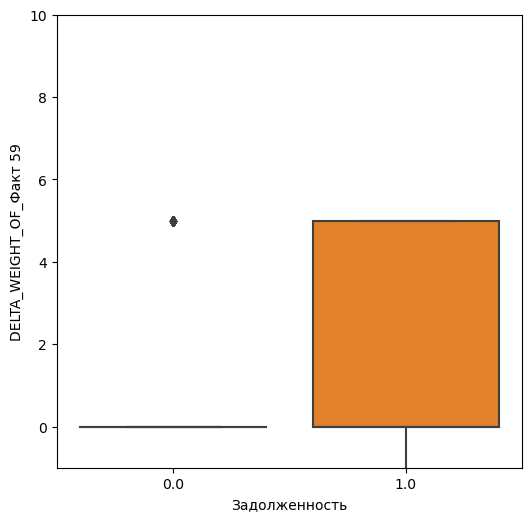

In [35]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
p=sns.boxplot(y=features_current['DELTA_WEIGHT_OF_Факт 59'], x=features_current['Задолженность'])
p.set(ylim=(-1, 10));

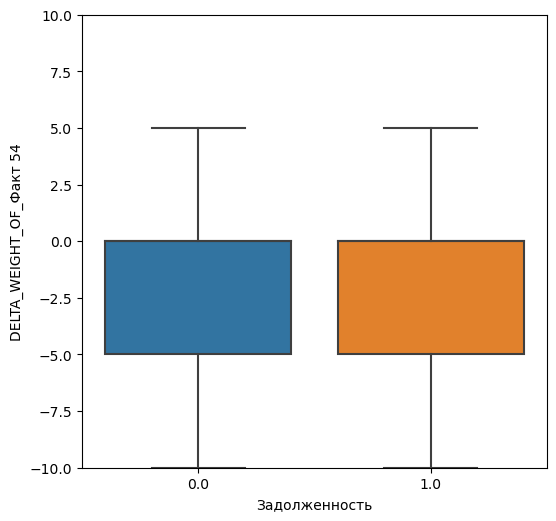

In [36]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
p=sns.boxplot(y=features_current['DELTA_WEIGHT_OF_Факт 54'], x=features_current['Задолженность'])
p.set(ylim=(-10, 10));

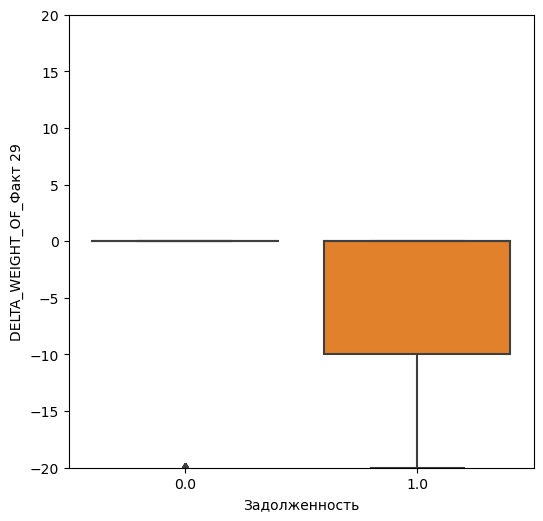

In [37]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
p=sns.boxplot(y=features_current['DELTA_WEIGHT_OF_Факт 29'], x=features_current['Задолженность'])
p.set(ylim=(-20, 20));

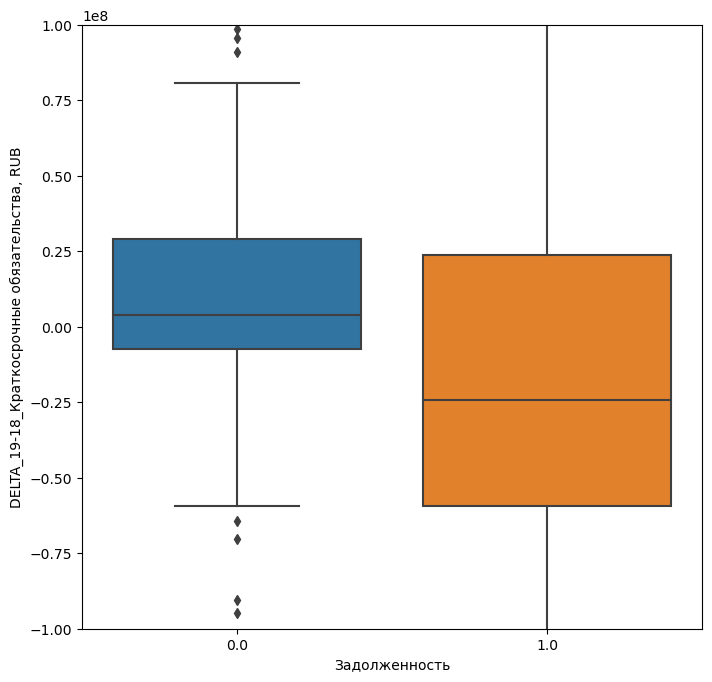

In [38]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_current['DELTA_19-18_Краткосрочные обязательства, RUB'], x=features_current['Задолженность'])
p.set(ylim=(-10**8, 10**8));

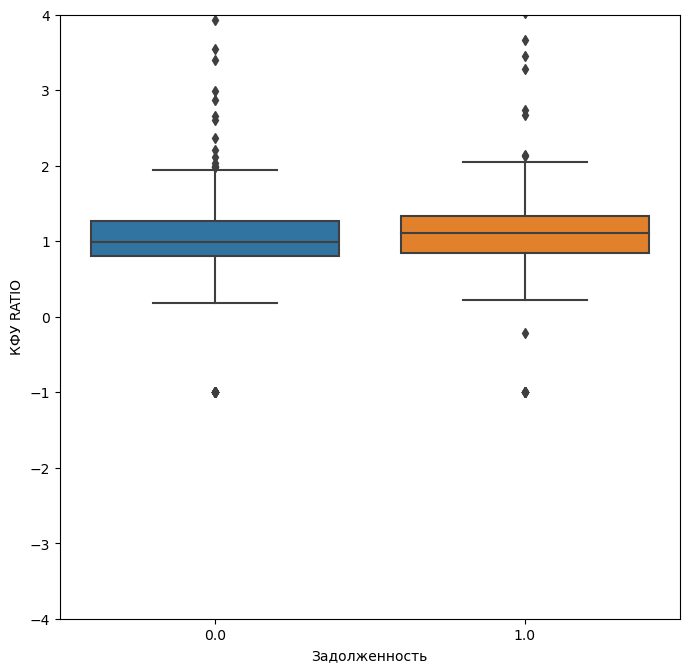

In [39]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_current['КФУ RATIO'], x=features_current['Задолженность'])
p.set(ylim=(-4, 4));